In [1]:
import os
import csv
import numpy as np 
import pickle
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
import keras.layers as layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
import random
tensorflow.keras.backend.clear_session()


Using TensorFlow backend.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data 0


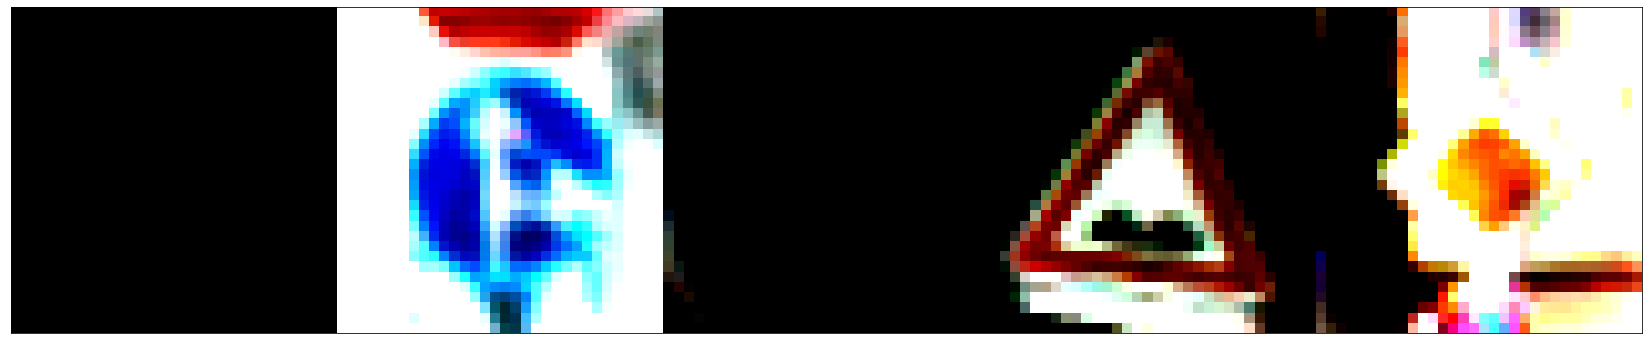

In [2]:
#Initialize List to Append each data file
data=[]
DATA_PATH = '/datasets/home/21/321/ee228sp20ta1/G36/'
#'Different Data Files' for training,  validation adn test
filenames=['processed_data.pickle']
# i=0
def show_data(data, num_exp):
    '''
    Display some random instances
    of input data.
    
    Input:-
    -----
    data :  type(4-D array)
        Input data in the form
        of images
        
    '''
    assert 0<=num_exp<=5

    x=[np.array([i]) for i in np.arange(data.shape[0])]
    rnd_ind = random.choices(x, k = num_exp)
    images = (data[rnd_ind,:,:,:]).squeeze(1)
    h_stack_image =np.hstack(images) # Getting Incorrect Images and Stacking
                                 # them to print in one go
    plt.figure(figsize = (30,6))
    plt.imshow(h_stack_image, cmap='gray')    # Converting into unsigned integers for plt.imshow              
    plt.xticks([])
    plt.yticks([])
        
#Read each data file from filesname
for i,fil in enumerate(filenames):
    #Read Path of the directory of datafiles
    #Use readbyte to read the data
    
    file= os.path.join(DATA_PATH, fil)
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  
        #Append currect data file to data <List>
        data.append(d)
   
        # Converting labels of data into one-hot vector
        data[i]['y_train'] = to_categorical(data[i]['y_train'], num_classes=43)
        data[i]['y_val'] = to_categorical(data[i]['y_val'], num_classes=43)
        data[i]['y_test'] = to_categorical(data[i]['y_test'], num_classes=43)
        
        
        #normalization and transpose to make number of channels at the end

        data[i]['x_train'] = (data[i]['x_train'])
        data[i]['x_val'] = (data[i]['x_val'])
        data[i]['x_test'] = (data[i]['x_test'])
        print('data', i)
        
        show_data(data[i]['x_train'], 5)
        # Showing shape of each data pickle (uncomment if needed)
        '''
        for k, j in data[i].items():
                if k == 'labels':
                   print(k + ':', len(j))
                else: 
                   print(k + ':', j.shape)
        print(i)
        '''
        # Show some random images of each data pickle (uncomment if needed)
        
#         i+=1

In [3]:
class Model():
    '''
    Class
       Variables:-
       ---------
       self.input_dim : type(int)
           Number of channels of input
           image of the data e.g rgb image
           has input_dim =3

       self.model : type(keras model)
           Its flexible to be changed

        self.model_name : type(str)
            Type of model to be implemented
    '''
    def __init__(self, input_dim, model_name):

        assert input_dim==1 or input_dim==3

        self.input_dim = input_dim
        self.model_name = model_name

        #Model Implementation        
        if(model_name=="AlexNet"):
            self.model = tf.keras.Sequential([
                         tf.keras.layers.Conv2D(64, 1, activation='relu', input_shape=(32,32,input_dim)),
                         tf.keras.layers.Conv2D(128, 3, activation='relu'),
                         tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
                         tf.keras.layers.Conv2D(128, 5, activation='relu',padding="same"),
                         tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(300, activation='relu'),
                         tf.keras.layers.Dense(43, activation='softmax')
                    ])
#         elif(model_name == "VGG19"):

#         elif(model_name == "CNN" ):

#         elif(model_name == "RNN" ):


        
    def compile_model(self, learn_rate = 0.001, initial_learning_rate = 0.0001,decay_steps=80000, decay_rate=1):
        '''
        Compiles user defined model
        based on input parameters.
        It also provides the option 
        of learning rate decay by
        specifying initial_learning_rate,
        decay_steps, decay_rate=1.
        It uses Adam optimization 
        and Categorical Cross Entropy Loss 
        Function but can be changed.

        Input:-
        -----
        learn_rate: type(float) 
            It defines learning rate
            of the optimizer

         initial_learning_rate :type(float)
            It defines initial learning
            rate of the optimizer if user
            wants to set exponential decay

        decay_steps: type(number)
            It defines number of decay 
            steps of the learning rate
            scheduler

        '''
        
#         initial_learning_rate = 0.0001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate,
                      decay_steps=decay_steps,
                      decay_rate=decay_rate,
                      staircase=True)
        
        
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                            metrics=['accuracy'])
    
    def train_model(self, x_train, y_train, x_val, y_val, epoch = 5,  batch_sz= 128, shuffle=False):
        '''
        Trains user defined model 
        based on input parameters.
        
        Input:-
        -----
        x_train :  type(4-D array)
            Input training data in
            the form of images
        y_train :  type(2-D array)
            Labels of input training 
            data in the form of one
            hot encoding vectors
        x_val :  type(3-D array)
            Input validation data in
            the form of images
        y_val :  type(2-D array)
            Labels of input validation
            data data in the form of one
            hot encoding vectors
        epoch: type(int)
            Number of epochs for training
        batch_sz: type(int) 
            Batch size for training of data
        shuffle : type(bool)
            If true, it tells the
            model to shuffle input data
            before training. Opposite
            is true shuffle is false
            
        Output:
        ------
            Returns trained model
        
        '''
        
        return self.model.fit(x_train,y_train,validation_data = (x_val,y_val),
                   batch_size=batch_sz,epochs=epoch, verbose=1, shuffle=shuffle, initial_epoch=0)
    
    
    def evaluate_model(self, x_test, y_test):
        '''
        Evaluate prediction accuracy 
        and loss value of the trained 
        model onto test data.
        
        Input:-
        -----
        x_test :  type(4-D array)
            Input test data in the
            form of images.
        y_test :  type(2-D array)
            Labels of input test data
            in the form of one hot
            encoding vectors.
       
    
        Output:-
        ------
        Returns prediction accuracy 
        and loss value of the trained 
        model onto test data.
        
        '''
        
        return self.model.evaluate(x_test, y_test, verbose = 2)
    
    def predict_label(self, x_test):
        '''
        Returns labels of input test
        data in the form of one hot
        encoding vectors.

        Input:
        x_test :  type(4-D array) 
            Input test data in the form of images
    
        Output:
        ------
        Returns a type(2-D array)
        predicted labels of input
        test data in the form of
        one hot encoding vectors
        
        '''
        
        return self.model.predict(x_test)
    
    
    def show_incorrect_examples(self, y_predict, x_test, y_test, num_exp):
        '''  
        Show num_exp number of incorrectly
        predicted examples by the trained
        model and print corresponding ground
        truth and model alongside.

        Input:-
        -----
        x_test :  type(3-D array) 
        Input test data in the form of images

        y_test :  type(2-D array)
         Labels of input test data in the
         form of one hot encoding vectors

        y_predict : type(2-D array)
         Predicted labels of input test 
         data in the form of one hot encoding vectors

        num_exp: type (int)
         Defines the number of incorrect
         examples to display its value
         must be less than 6 and positive
        '''
        assert 0<=num_exp<=5
        
        y_predict_id = np.argmax(y_predict, axis=1)    #Collecting true category from one hot encoding vector
        y_test_id = np.argmax(y_test, axis =1)         #Collecting true category from one hot encoding vector

        image_data = x_test
        false_preds_ind = np.argwhere(y_predict_id!=y_test_id)  #Indices where prediction is incorrect

        rnd_ind = random.choices(false_preds_ind, k = num_exp)
        print(rnd_ind) 

        false_pred_images = (image_data[rnd_ind,:,:,:]).squeeze(1)

        h_stack_image     =np.hstack(false_pred_images) #Getting Incorrect Images and Stacking
                                                                                       # them to print in one go

        plt.figure(figsize = (30,6))

        plt.imshow(h_stack_image.astype('uint8'), cmap='gray')    # Converting into unsigned integers for plt.imshow              
        plt.xticks([])
        plt.yticks([])

        print('Ground_Truth ', y_test_id[np.ravel(rnd_ind)])  #Printing the true categories
        print('Prediction ', y_predict_id[np.ravel(rnd_ind)])
        
    def show_correct_examples(self, y_predict,x_test, y_test, num_exp):
        '''  
        Show num_exp number of correctly
        predicted examples by the trained
        model and print corresponding 
        ground truth and model alongside.

        Input:-
        -----
        x_test :  type(3-D array) 
         Input test data in the form of images

        y_test :  type(2-D array)
         Labels of input test data in
         the form of one hot encoding vectors

        y_predict : type(2-D array)
         Predicted labels of input test
         data in the form of one hot encoding vectors

        num_exp: type (int)
         It defines the number of correct
         examples to display its value
         must be less than 6 and positive
        '''
        assert num_exp<=5
        
        #Collecting true category from one hot encoding vector
        y_predict_id =   np.argmax(y_predict, axis=1)             

        #Collecting true category from one hot encoding vector   
        y_test_id    =   np.argmax(y_test, axis =1)         
        image_data   =   x_test


        #Indices where prediction is correct 
        corr_preds_ind=       np.argwhere(y_predict_id==y_test_id)  
        rnd_ind        =       random.choices(corr_preds_ind, k = num_exp)

        corr_pred_images = (image_data[rnd_ind,:,:,:]).squeeze(1)
        #Getting correct Images and Stacking them to print in one go 
        h_stack_image     =np.hstack(corr_pred_images) 


        plt.figure(figsize = (30,6))

        plt.imshow(h_stack_image.astype('uint8'), cmap='gray')    # Converting into unsigned integers for plt.imshow              
        plt.xticks([])
        plt.yticks([])
        print('Ground_Truth ', y_test_id[np.ravel(rnd_ind)])  #Printing the true categories
        print('Prediction ', y_predict_id[np.ravel(rnd_ind)])   #Printing the predicted categories
    
    def save(self, filename):
        '''
        Save the currect state of the
        model into file specified by
        the name as filename and delete
        that model to decrease load memory.
        
        Input:-
        -----
        filename: type(string)
            Specify name of the file in
            which you wnat to store
            the state of the model
        '''
        assert(isinstance(filename,str))
        
        self.model.save(filename)
        del self.model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 86989 samples, validate on 4410 samples
Epoch 1/5
86989/86989 [==============================] - 13s 154us/sample - loss: 0.5499 - acc: 0.8448 - val_loss: 0.4553 - val_acc: 0.8773
Epoch 2/5
86989/86989 [==============================] - 11s 131us/sample - loss: 0.0494 - acc: 0.9860 - val_loss: 0.6998 - val_acc: 0.8907
Epoch 3/5
86989/86989 [==============================] - 11s 132us/sample - loss: 0.0373 - acc: 0.9892 - val_loss: 0.3117 - val_acc: 0.9245
Epoch 4/5
86989/86989 [==============================] - 12s 135us/sample - loss: 0.0251 - acc: 0.9929 - val_loss: 0.4635 - val_acc: 0.9299
Epoch 5/5
86989/86989 [==============================] - 11s 131us/sample - loss: 0.0241 - acc: 0.9929 - val_loss: 0.3896 - val_acc: 0.9288
12630/12630 - 1s - loss: 0.4324 - acc: 0.9260
[array([5040]), array([8286]), array([8290]), array([3940]), array([8612])]
Ground_Trut

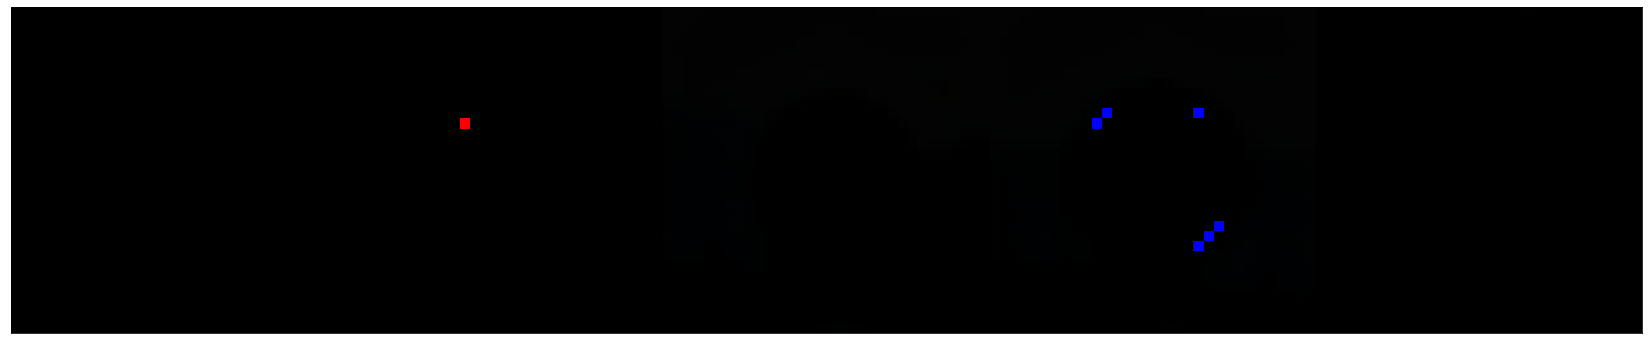

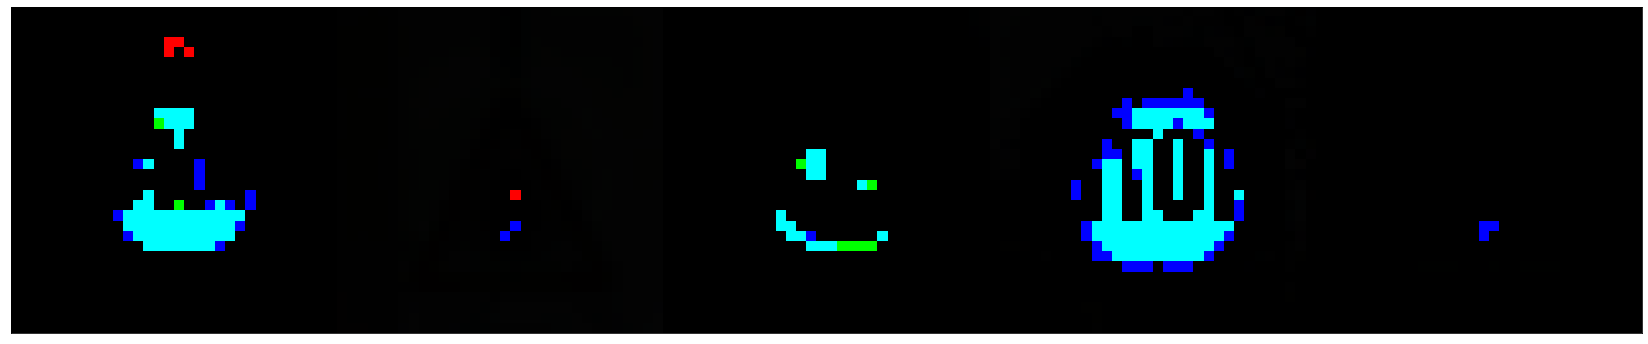

In [4]:
Model_Number=1
correct_img= 5
incorrect_img = 5
#Define the name of file in which you want to store train acc, val, acc_loss, val_loss line by line fr each data pickle
result_file='model'+str(Model_Number)+'.csv'
#Make sure you remove such file if it alread exists
'''os.remove(result_file)
'''


for k in range(0,1):
    input_dim = data[k]['x_train'].shape[3]
    xtrain =data[k]['x_train']
    ytrain=data[k]['y_train']
    xval= data[k]['x_val'] 
    yval= data[k]['y_val'] 
    xtest=data[k]['x_test'] 
    ytest=data[k]['y_test'] 
    #Define a new model instance  
    model_instance=Model(input_dim,'AlexNet')
    #Cpmiple the model
    model_instance.compile_model()

    #Train the model
    fit_history=model_instance.train_model(xtrain, ytrain, xval, yval)


    #Evaluate the model
    predict = model_instance.evaluate_model(xtest,ytest)

    # predicted labels  
    pred_label= model_instance.predict_label(xtest)


    #Create a new file and start saving data 
    with open(result_file, 'a', encoding = 'UTF-8', newline = '') as f:
        f.write( str(fit_history.history['acc'])[1:-1])
        f.write('\n')
        f.write(str(fit_history.history['val_acc'])[1:-1])
        f.write('\n')
        f.write(str(fit_history.history['loss'])[1:-1])
        f.write('\n')
        f.write(str(fit_history.history['val_loss'])[1:-1])
        f.write('\n')

    #Display incorrectly classified examples
    model_instance.show_incorrect_examples(pred_label,xtest,ytest, correct_img)

    #Display correctly classified examples      
    model_instance.show_correct_examples(pred_label,xtest,ytest, incorrect_img)  
    #defines file name to save the model state  
    model_filename='model'+str(Model_Number)+'data'+str(k)

    model_instance.save(model_filename)


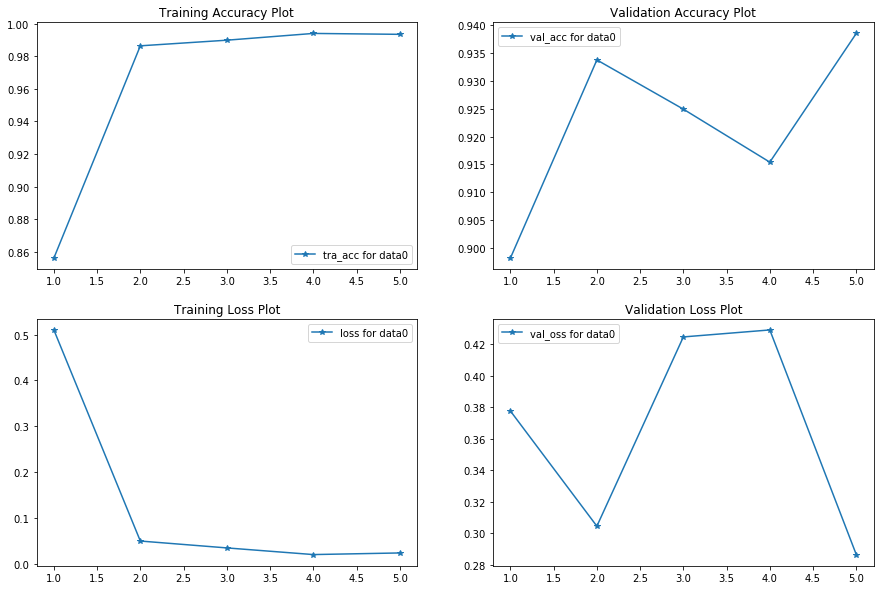

In [5]:
## Dsiplay Accuracy plot, loss plot for training data as well as validation data
#Defines the name of file from which data is to bread
result_file='model'+str(Model_Number)+'.csv'

epoch=5
plt.figure(figsize=(15,10))


def str_num(read_ptr):
    '''
    Read one input string by
    readptrd and Converts read
    input strings from the file
    into float values.
    
    Input:-
    -----
    read_ptr(pointer): Reader
    pointer to csv file.
    
    Output:-
    ------
    Float values corresponding
    to the read string.
    '''
    y=next(read_ptr)
    
    return [float(x)  for  x  in y]

with open(result_file, 'r') as f:
    reader=csv.reader(f, delimiter =',')
    for i in range(0,1):
        plt.subplot(2,2,1)
        y=str_num(reader)
        #Plot training accuracy and validation accuracy
        plt.plot(np.arange(1,epoch+1), y, marker='*', label = 'tra_acc for data'+ str(i))

        plt.title('Training Accuracy Plot')
        plt.legend()

        plt.subplot(2,2,2)
        y=str_num(reader)  
        plt.plot(np.arange(1,epoch+1), y, marker='*', label = 'val_acc for data'+ str(i))  
        plt.title('Validation Accuracy Plot')
        plt.legend()

        #Plot training loss and validation loss
        plt.subplot(2,2,3)
        y=str_num(reader)
        plt.plot(np.arange(1,epoch+1), y, marker= '*', label = 'loss for data'+ str(i))  
        plt.title('Training Loss Plot')
        plt.legend()


        plt.subplot(2,2,4)
        y=str_num(reader)
        plt.plot(np.arange(1,epoch+1), y, marker= '*',label = 'val_oss for data'+ str(i)) 
        plt.title('Validation Loss Plot')
        plt.legend()
         